In [2]:
!pip install meteocalc

  Created wheel for meteocalc: filename=meteocalc-1.1.0-cp37-none-any.whl size=8195 sha256=ace121271edc1773f753385660586c3a87c3dec7eada11d553ca04e0eac68972
  Stored in directory: /root/.cache/pip/wheels/9e/34/13/83d36ecc28837e3c2a5b696542e697538e7c1025382f4ded55
Successfully built meteocalc


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
#!unzip -q ashrae.zip

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.pylabtools import figsize
from plotly.offline import init_notebook_mode,iplot,plot
%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use("ggplot")
from sklearn.utils import shuffle

from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Model 
from keras.layers import Input, Dense, Lambda
from keras.layers import Embedding, Flatten, Dropout, Add, Activation
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint,EarlyStopping
import keras.backend as K

# importer les fichiers .py sur le notebook
%run utils.py
%run feature_enginering.py

In [4]:
building = pd.read_csv('/content/building_metadata.csv')
weather = pd.read_csv('/content/weather_train.csv')
train = pd.read_csv('/content/train.csv')

train.loc[(train.meter == 0),'meter_reading'] = train['meter_reading'] * 0.2931 # convertir du kwh vers kbtu

In [5]:
def join_data(data , weather_data , building_data):
    building_data = reduce_mem_usage(building_data)
    weather_data  = reduce_mem_usage(weather_data)
    data = reduce_mem_usage(data)

    weather_data = prepare_weather_data(weather_data)
    building_data = prepare_building_data(building_data)
    data  = time_features(data)
    
    data = data.merge(building_data, left_on = "building_id", right_on = "building_id", how = "left")
    data = data.merge(weather_data, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"])

    data = shuffle(data, random_state=0)
    
    data = reduce_mem_usage(data)
    return data

In [6]:
train = join_data(train , weather , building)

train['log_meter_reading'] = np.log(train['meter_reading'] + 1)
train['month_group'] = train['month_group'] - 1

del weather, building
gc.collect()

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 65.4%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 4.51 MB
Decreased by 53.0%
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 2361.15 MB
Memory usage after optimization is: 1401.49 MB
Decreased by 40.6%


49

In [7]:
train = train.drop(['meter_reading'] , axis= 1)

,building_id,meter,timestamp,hour,dayofweek,month_group,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,relative_humidity,feels_like,city,country,is_holiday,log_meter_reading
2217631,79,0,2016-02-10 16:00:00,16,2,0,0,Office,36240,2010.000000,0.0,11.700000,2.000000,-5.000000,0.000000,1024.099976,300.0,6.7,30.736702,53.060001,Orlando,US,0,0.000000
14843430,43,1,2016-09-28 17:00:00,17,2,2,0,Retail,59071,1980.000000,0.0,31.100000,2.222222,21.100000,0.000000,1015.700012,190.0,3.6,55.346207,93.080376,Orlando,US,0,6.688351
17098627,769,2,2016-11-07 18:00:00,18,0,2,6,Education,77263,1967.957031,0.0,17.200001,0.000000,0.000000,0.000000,1030.599976,0.0,0.0,31.195812,62.960003,Washington,US,0,4.678588
10198113,774,0,2016-07-07 08:00:00,8,3,1,6,Lodging/residential,93500,1967.957031,0.0,23.299999,0.000000,22.200001,0.000000,1009.500000,0.0,0.0,93.547615,73.940002,Washington,US,0,2.558731
15314118,1040,0,2016-10-07 00:00:00,0,4,2,12,Office,126960,1967.957031,0.0,10.300000,1.000000,6.600000,4.142857,1023.700012,100.0,6.0,77.832932,50.540001,Dublin,Ireland,0,3.926159


In [8]:
print(len(train.columns))
print(train.columns)
print(train.shape)

24
Index(['building_id', 'meter', 'timestamp', 'hour', 'dayofweek', 'month_group',
       'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'relative_humidity', 'feels_like', 'city', 'country',
       'is_holiday', 'log_meter_reading'],
      dtype='object')
(20125605, 24)


In [9]:
cols_to_drop = ['year_built' , 'floor_count' , 'timestamp']

cols_to_scale = ['square_feet' , 'air_temperature' , 'dew_temperature' ,
                 'wind_speed', 'cloud_coverage', 'sea_level_pressure', 'wind_direction',
                 'relative_humidity', 'feels_like']

cols_to_encode = ['primary_use' , 'city' , 'country']

ScalerEncoder = Data_Scaler_Encoder(cols_to_scale , cols_to_drop , cols_to_encode)
ScalerEncoder.fit(train)
train = ScalerEncoder.transform(train)

In [10]:
for col in train.columns:
  if train[col].isnull().values.any():
    print(col , 'il y a', train[col].isnull().values.sum() , ' Nan ')

In [11]:
def residual_block(input_x, nodes):
    d1 = Dense(nodes,activation='relu')(input_x)
    d2 = Dense(nodes,activation='relu')(d1)

    projected_x = Dense(nodes,activation='relu')(input_x)

    add = Add()([projected_x , d2])
    return add

def create_model(data , categorical_vars , numerical_vars):
    categ_inputs = []
    embed_layers = []  
    for col in categorical_vars:
        num_classes = len(np.unique(data[col]))

        input_x = Input(shape = [1] , name = col)
        categ_inputs.append(input_x)

        embed_x = Embedding(num_classes, 2)(input_x)
        embed_layers.append(embed_x)

    num_inputs = []
    for col in numerical_vars:
        num_inputs.append(Input(shape=[1] , name = col))

    concat_emb = K.concatenate([Flatten()(emb_layer) for emb_layer in embed_layers])

    d1 = residual_block(concat_emb , 512)
    main = K.concatenate(num_inputs+[d1])

    d2 = residual_block(main , 512)
    d3 = residual_block(d2 , 8)
    df = Dense(4 , name='second_to_last_layer')(d3)

    output = Dense(1 )(df)
    model  = Model(categ_inputs + num_inputs, output)

    return model 

def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
train.head()

,building_id,meter,hour,dayofweek,month_group,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,relative_humidity,feels_like,city,country,is_holiday,log_meter_reading
2217631,79,0,16,2,0,0,6,-0.610650,-0.412257,-0.131424,-1.270034,0.000000,1.080684,1.204127,1.452095,-1.418302,-0.333380,5,3,0,0.000000
14843430,43,1,17,2,2,0,11,-0.415783,1.393175,-0.045833,1.333444,0.000000,1.011605,0.211103,0.047097,-0.324852,1.583867,5,3,0,6.688351
17098627,769,2,18,0,2,6,0,-0.260510,0.099592,-0.901748,-0.771283,0.000000,1.134138,-1.504119,-1.584513,-1.397903,0.140897,12,3,0,4.678588
10198113,774,0,8,3,1,6,4,-0.121924,0.667279,-0.901748,1.443169,0.000000,0.960617,-1.504119,-1.584513,1.372513,0.666913,12,3,0,2.558731
15314118,1040,0,0,4,2,12,6,0.163665,-0.542546,-0.516586,-0.112932,4.142857,1.077395,-0.601370,1.134837,0.674278,-0.454106,2,0,0,3.926159


In [13]:
categorical_vars = ['building_id' , 'meter', 'hour', 'dayofweek' , 'month_group', 'site_id' , 
                    'primary_use', 'city', 'country', 'is_holiday']
                    
numerical_vars = ['square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
                  'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 
                  'relative_humidity' , 'feels_like']

target_var = 'log_meter_reading'

model = create_model(train, categorical_vars, numerical_vars)

In [14]:
y = train[target_var].values
y = y.reshape((len(y) , 1))

train = train.drop( [target_var] , axis = 1)

co_vars = categorical_vars + numerical_vars
train = train[co_vars].values

train = [ train[:,i].flatten() for i in range(len(train[0,:])) ]

In [15]:

checkpoint = ModelCheckpoint( '/content/drive/MyDrive/model_ann.h5', 
                                monitor='loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

early_stopping = EarlyStopping(patience = 5 ,monitor = "val_rmse")
callbacks_list = [checkpoint , early_stopping]

model.compile(optimizer = Adam(lr=1e-4), loss = 'mse',  metrics = [rmse])
history_1 = model.fit(train, y, epochs = 75, batch_size = 1024, callbacks = callbacks_list, validation_split = 0.1)

Epoch 1/75
17689/17689 [==============================] - 156s 9ms/step - loss: 1.5594 - rmse: 1.1845 - val_loss: 0.8209 - val_rmse: 0.9040

Epoch 00001: loss improved from inf to 1.06216, saving model to /content/drive/MyDrive/model_ann.h5
Epoch 2/75
17689/17689 [==============================] - 150s 8ms/step - loss: 0.7950 - rmse: 0.8897 - val_loss: 0.7465 - val_rmse: 0.8622

Epoch 00002: loss improved from 1.06216 to 0.77695, saving model to /content/drive/MyDrive/model_ann.h5
Epoch 3/75
17689/17689 [==============================] - 149s 8ms/step - loss: 0.7303 - rmse: 0.8526 - val_loss: 0.6930 - val_rmse: 0.8304

Epoch 00003: loss improved from 0.77695 to 0.72025, saving model to /content/drive/MyDrive/model_ann.h5
Epoch 4/75
17689/17689 [==============================] - 149s 8ms/step - loss: 0.6862 - rmse: 0.8264 - val_loss: 0.6587 - val_rmse: 0.8095

Epoch 00004: loss improved from 0.72025 to 0.67826, saving model to /content/drive/MyDrive/model_ann.h5
Epoch 5/75
17689/17689 [

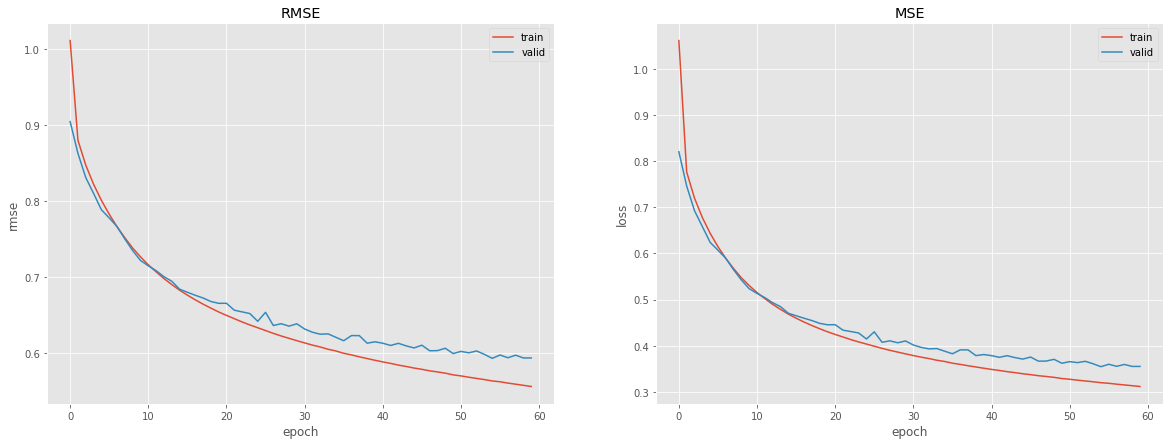

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize = (20,7))

ax1.plot(history_1.history['rmse'])
ax1.plot(history_1.history['val_rmse'])
ax1.set_title('RMSE')
ax1.set_ylabel('rmse')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(history_1.history['loss'])
ax2.plot(history_1.history['val_loss'])
ax2.set_title('MSE')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'valid'], loc='upper right')

plt.show()